In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)


In [2]:
motif_indexes = []
n = 1000
p = 5
k = 100

start = 0
while len(motif_indexes) < k:
    if len(motif_indexes) % 2 == 0:
        start += p
    else:
        start += 2 * p
    motif_indexes.append(start)

motif_indexes = sorted(motif_indexes)
#normalize the data
motif_indexes = [idx / n for idx in motif_indexes]
motif_indexes


[0.005,
 0.015,
 0.02,
 0.03,
 0.035,
 0.045,
 0.05,
 0.06,
 0.065,
 0.075,
 0.08,
 0.09,
 0.095,
 0.105,
 0.11,
 0.12,
 0.125,
 0.135,
 0.14,
 0.15,
 0.155,
 0.165,
 0.17,
 0.18,
 0.185,
 0.195,
 0.2,
 0.21,
 0.215,
 0.225,
 0.23,
 0.24,
 0.245,
 0.255,
 0.26,
 0.27,
 0.275,
 0.285,
 0.29,
 0.3,
 0.305,
 0.315,
 0.32,
 0.33,
 0.335,
 0.345,
 0.35,
 0.36,
 0.365,
 0.375,
 0.38,
 0.39,
 0.395,
 0.405,
 0.41,
 0.42,
 0.425,
 0.435,
 0.44,
 0.45,
 0.455,
 0.465,
 0.47,
 0.48,
 0.485,
 0.495,
 0.5,
 0.51,
 0.515,
 0.525,
 0.53,
 0.54,
 0.545,
 0.555,
 0.56,
 0.57,
 0.575,
 0.585,
 0.59,
 0.6,
 0.605,
 0.615,
 0.62,
 0.63,
 0.635,
 0.645,
 0.65,
 0.66,
 0.665,
 0.675,
 0.68,
 0.69,
 0.695,
 0.705,
 0.71,
 0.72,
 0.725,
 0.735,
 0.74,
 0.75]

In [3]:
def split_sequence(data, look_back=1):
    X, y = list(), list()
    for idx in range(len(data)- look_back -1):
        data_x, data_y = data[idx:idx+look_back], data[idx+look_back]
        X.append(data_x)
        y.append(data_y)
    return np.array(X), np.array(y)

In [4]:
X, y = split_sequence(motif_indexes, look_back=10)
for i in range(len(X)):
 print(X[i], y[i])

[0.005 0.015 0.02  0.03  0.035 0.045 0.05  0.06  0.065 0.075] 0.08
[0.015 0.02  0.03  0.035 0.045 0.05  0.06  0.065 0.075 0.08 ] 0.09
[0.02  0.03  0.035 0.045 0.05  0.06  0.065 0.075 0.08  0.09 ] 0.095
[0.03  0.035 0.045 0.05  0.06  0.065 0.075 0.08  0.09  0.095] 0.105
[0.035 0.045 0.05  0.06  0.065 0.075 0.08  0.09  0.095 0.105] 0.11
[0.045 0.05  0.06  0.065 0.075 0.08  0.09  0.095 0.105 0.11 ] 0.12
[0.05  0.06  0.065 0.075 0.08  0.09  0.095 0.105 0.11  0.12 ] 0.125
[0.06  0.065 0.075 0.08  0.09  0.095 0.105 0.11  0.12  0.125] 0.135
[0.065 0.075 0.08  0.09  0.095 0.105 0.11  0.12  0.125 0.135] 0.14
[0.075 0.08  0.09  0.095 0.105 0.11  0.12  0.125 0.135 0.14 ] 0.15
[0.08  0.09  0.095 0.105 0.11  0.12  0.125 0.135 0.14  0.15 ] 0.155
[0.09  0.095 0.105 0.11  0.12  0.125 0.135 0.14  0.15  0.155] 0.165
[0.095 0.105 0.11  0.12  0.125 0.135 0.14  0.15  0.155 0.165] 0.17
[0.105 0.11  0.12  0.125 0.135 0.14  0.15  0.155 0.165 0.17 ] 0.18
[0.11  0.12  0.125 0.135 0.14  0.15  0.155 0.165 0.17  0

In [5]:
#pad sequences putting zeros at the beginning
from keras.preprocessing.sequence import pad_sequences
X = pad_sequences(X,  maxlen=3, padding='pre', truncating='pre', value=-1, dtype=float)
X[-1]

array([0.72 , 0.725, 0.735])

In [6]:
#train are the first 80% of the X
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

#reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0],  X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

X_train.shape

(71, 3, 1)

In [7]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [8]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

def create_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Masking(mask_value=-1))
    hp_units = hp.Int('units', min_value=2, max_value=12, step=1)
    model.add(LSTM(units=hp_units, activation='relu', return_sequences=False))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

In [9]:
import keras_tuner as kt
from keras.callbacks import EarlyStopping


tuner= kt.RandomSearch(
        create_model,
        objective='mae',
        max_trials=50,
        executions_per_trial=3,
        project_name='lstm_tuning'
        )

tuner.search(
        x=X_train,
        y=y_train,
        epochs=300,
        batch_size=32,
        validation_data=(X_test,y_test)
        #callbacks=[EarlyStopping('val_loss', patience=5)]
        )


Reloading Tuner from ./lstm_tuning/tuner0.json


In [10]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
tuner.results_summary()


Results summary
Results in ./lstm_tuning
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 14 summary
Hyperparameters:
units: 10
learning_rate: 0.01
Score: 0.001632041724709173

Trial 03 summary
Hyperparameters:
units: 12
learning_rate: 0.01
Score: 0.001633973908610642

Trial 09 summary
Hyperparameters:
units: 8
learning_rate: 0.01
Score: 0.0016635231052835782

Trial 11 summary
Hyperparameters:
units: 9
learning_rate: 0.01
Score: 0.0017100654852886994

Trial 08 summary
Hyperparameters:
units: 6
learning_rate: 0.01
Score: 0.0017128710945447285

Trial 18 summary
Hyperparameters:
units: 3
learning_rate: 0.01
Score: 0.0017240438998366396

Trial 17 summary
Hyperparameters:
units: 11
learning_rate: 0.01
Score: 0.0017750317929312587

Trial 13 summary
Hyperparameters:
units: 7
learning_rate: 0.01
Score: 0.001775855237307648

Trial 01 summary
Hyperparameters:
units: 10
learning_rate: 0.001
Score: 0.002961325847233335

Trial 20 summary
Hyperparameters:
units: 9
learning_rate: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
MSE: 9.545381926041184e-06
MAE: 0.0025556050406561983
R2: 0.9936628169785618


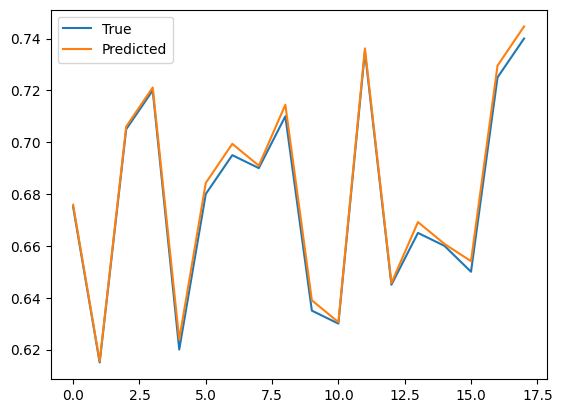

In [12]:
#evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()

In [13]:
#create synthetic time series random uniform integers
n = 1000
time = np.arange(0, n, 1)
data = np.random.randint(0, 6, n)

#select random timewindows of length 5 without overlapping
motif_indexes = []
k = 100
motif_pattern = [1,3,5,3,1]
p = len(motif_pattern)
available_starts = list(range(n - p))

start = 0
for i in range(k):
    if not available_starts:
        break
    start = np.random.choice(available_starts)
    motif_indexes.append(start)
    available_starts = [idx for idx in available_starts if not idx in range(start - p, start + p)]

motif_indexes = sorted(motif_indexes)

In [14]:
#change the values of the time series in the selected timewindows to the motif pattern
for idx in motif_indexes:
    data[idx:idx+p] = motif_pattern
data

array([5, 1, 3, 5, 3, 1, 4, 1, 1, 3, 5, 3, 1, 5, 3, 1, 3, 5, 3, 1, 0, 4,
       1, 4, 3, 4, 1, 3, 5, 3, 1, 5, 2, 2, 2, 3, 1, 3, 5, 3, 1, 4, 0, 0,
       5, 5, 2, 4, 0, 4, 1, 3, 5, 3, 1, 0, 1, 1, 3, 5, 3, 1, 2, 2, 4, 5,
       0, 1, 3, 3, 5, 3, 1, 1, 1, 3, 5, 3, 1, 3, 4, 1, 4, 0, 1, 3, 5, 3,
       1, 4, 3, 4, 0, 2, 1, 3, 0, 3, 5, 1, 3, 5, 2, 3, 3, 1, 5, 1, 2, 3,
       2, 3, 2, 3, 0, 4, 0, 1, 3, 5, 3, 1, 0, 2, 1, 3, 5, 3, 1, 2, 2, 2,
       1, 1, 3, 5, 3, 1, 4, 1, 3, 5, 3, 1, 1, 0, 1, 1, 3, 5, 3, 1, 5, 3,
       1, 3, 5, 3, 1, 5, 5, 5, 1, 3, 5, 3, 1, 1, 3, 5, 3, 1, 3, 5, 1, 3,
       5, 3, 1, 2, 1, 3, 5, 3, 1, 1, 1, 1, 3, 5, 3, 1, 1, 0, 4, 2, 1, 3,
       5, 3, 1, 3, 5, 4, 3, 2, 0, 1, 3, 5, 3, 1, 5, 4, 2, 2, 3, 1, 3, 5,
       3, 1, 4, 0, 5, 5, 3, 1, 0, 1, 3, 5, 3, 1, 4, 0, 1, 3, 5, 3, 1, 1,
       3, 5, 3, 1, 5, 5, 1, 3, 5, 3, 1, 3, 1, 5, 2, 4, 1, 3, 5, 3, 1, 4,
       0, 3, 2, 1, 5, 2, 2, 3, 1, 3, 5, 3, 1, 1, 3, 5, 3, 1, 4, 2, 3, 3,
       3, 3, 1, 1, 3, 5, 3, 1, 5, 5, 0, 3, 2, 1, 3,

In [15]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data, look_back, motif_indexes):
    X1, X2, y1, y = list(), list(), list(), list()
    for idx in range(len(data)- look_back -1):
        next_motif_idx = [motif_idx for motif_idx in motif_indexes if motif_idx > idx + look_back]
        dist_to_next_motif = next_motif_idx[0] - idx if next_motif_idx else -1
        data_x1 = data[idx:idx+look_back]
        data_x2 = [motif_idx for motif_idx in motif_indexes if motif_idx <= idx+look_back]
        data_y1 = data[idx+look_back]
        data_y = dist_to_next_motif
        X1.append(data_x1)
        X2.append(data_x2)
        y1.append(data_y1)
        y.append(data_y)

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2), np.array(y1), np.array(y)

In [16]:
look_back = 50
X1, X2, y1, y  = create_dataset(data, look_back=look_back, motif_indexes=motif_indexes)
print(X1[0], X2[0], y1[0], y[0])

[5 1 3 5 3 1 4 1 1 3 5 3 1 5 3 1 3 5 3 1 0 4 1 4 3 4 1 3 5 3 1 5 2 2 2 3 1
 3 5 3 1 4 0 0 5 5 2 4 0 4] [ 1  8 15 26 36 50 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1] 1 57


In [19]:
X1.shape

(949, 50)

In [21]:
#train are the first 80% of the X
X1_train = X1[:int(0.8*len(X1))]
X2_train = X2[:int(0.8*len(X2))]
X1_test = X1[int(0.8*len(X1)):]
X2_test = X2[int(0.8*len(X2)):]
y1_train = y1[:int(0.8*len(y1))]
y_train = y[:int(0.8*len(y))]
y1_test = y1[int(0.8*len(y1)):]
y_test = y[int(0.8*len(y)):]


from sklearn.utils import shuffle
X1_train, X2_train, y1_train = shuffle(X1_train, X2_train, y1_train)
X1_test, X2_test, y1_test = shuffle(X1_test, X2_test, y1_test)

#reshape input to be [samples, time steps, features]
X1_train = np.reshape(X1_train, (X1_train.shape[0],  X1_train.shape[1], 1))
X1_test = np.reshape(X1_test, (X1_test.shape[0],  X1_test.shape[1], 1))

X1_train.shape

(759, 50, 1)

In [35]:
def create_model_embeddinglstm(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, activation='tanh', return_sequences=False))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001])
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae'])
    return model

import keras_tuner as kt
from keras.callbacks import EarlyStopping

tuner= kt.RandomSearch(
        create_model_embeddinglstm,
        objective='mae',
        max_trials=10,
        executions_per_trial=3,
        project_name = 'embeddinglstm'
        )

tuner.search(
        x=X1_train,
        y=y1_train,
        epochs=500,
        batch_size=32
        )



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.01              |0.01              |learning_rate

Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3578 - mae: 1.6750
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4975 - mae: 1.3516
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4885 - mae: 1.3673
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4620 - mae: 1.3664
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4166 - mae: 1.3280
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.4134 - mae: 1.3460
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5372 - mae: 1.3419
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3689 - mae: 1.3116
Epoch 9/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.3331 - mae: 1.3073
Epoch 10/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.2883 - mae: 1.2669
Epoch 11/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - l

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


/home/mgsilva/miniconda3/envs/motifpredenv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

y_train = best_model.predict(X_train)
mse = mean_squared_error(y, y_train)
mae = mean_absolute_error(y, y_train)
r2 = r2_score(y, y_train)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

plt.plot(y, label='True')



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


MSE: 0.005253280321710496
MAE: 0.05478046589413994
R2: 0.9979532719276796
